In [28]:
# from google.colab import files
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import transformers
import random, re
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
# from focal_loss.focal_loss import FocalLoss
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package punkt to /home2/rishabhk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home2/rishabhk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# files.upload()
# !mkdir /root/.kaggle/
# !mv /content/kaggle.json /root/.kaggle/kaggle.json
# !kaggle datasets download -d thedevastator/nlp-mental-health-conversations
# !rm /root/.kaggle/kaggle.json
# !unzip /content/nlp-mental-health-conversations.zip
# !rm /content/nlp-mental-health-conversations.zip

In [3]:
PUNCTUATIONS = ". ? ' \" - [ ] { } ( ) ... : ;"
PUNCTUATIONS = PUNCTUATIONS.split(" ")
print("Number of punctuations:", len(PUNCTUATIONS))

Number of punctuations: 14


In [4]:
# all_sents = pd.read_csv("/content/train.csv")["Response"].tolist()[:2]
all_sents = pd.read_csv("./train.csv")["Response"].tolist()[:300]

In [5]:
def remove_punc(sent_in):
  fin = ""
  for i in sent_in:
    if (i.isalnum()) or (i in PUNCTUATIONS+["<", ">", " "]):
      fin += i
  return fin
def clean_text(all_sent):
  """
    This functions cleans the given text by performing the following changes
    - remove Nan
    - replace "\xa0" with " "
    - replace "\n", "\r", '\t" with " "
    - replace multiple spaces with single space
    - lowercase
    - tokenize the sentences
    - <URL> for urls
    - <NUM> for numbers
    - <PHNUM> for phone numbers [NUM-NUM-NUM-NUM], [NUM-NUM-NUM]
    - <DATE> for dates
    - Replace 3+ consecutive periods with an ellipse.
    - Ensure all punctutions have a space before and after it
    - Remove all other special charectors
  """
  all_sent = [sent for sent in all_sent if type(sent)==type("string")]  # remove nan
  fin = []
  for sent in all_sent:
    fin += nltk.tokenize.sent_tokenize(sent.replace('\xa0', ' ').replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').lower())
  fin = [re.sub(r'\d+', "<NUM>", sent) for sent in fin]  # Numbers
  # Ph. num
  fin = [sent.replace("<NUM>-<NUM>-<NUM>-<NUM>", "<PHNUM>") for sent in fin]
  fin = [sent.replace("<NUM>-<NUM>-<NUM>", "<PHNUM>") for sent in fin]
  # Dates
  fin = [sent.replace("<NUM>/<NUM>/<NUM>", "<DATE>") for sent in fin]
  fin = [re.sub(r'https?://\S+|www\.\S+', "<URL>", sent) for sent in fin]  # URLs
  fin = [re.sub(r'\.{4,}', '...', sent) for sent in fin]  # Multiple periods
  # space around punctuations
  for pun in PUNCTUATIONS:
    fin = [sent.replace(pun, " " + pun + " ") for sent in fin]
  fin = [re.sub(r' +', " ", sent) for sent in fin]  # Remove multiple Spaces
  # remove other special charectors
  fin = [remove_punc(sent) for sent in fin]
  return fin

In [6]:
def lemmatize_text(all_sent):
    fin = []
    lemmatizer = WordNetLemmatizer()
    for sent in all_sent:
      tokens = sent.split(" ")
      lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
      lemmatized_tokens  = [i for i in lemmatized_tokens if len(i)]
      fin += [lemmatized_tokens]
    fin = [i for i in fin if len(i)]
    return fin

# Split the sentences

In [7]:
# fraction of dataset to alot for each split
TRAIN, VAL, TEST = 0.7, 0.1, 0.2

In [8]:
all_sents = clean_text(all_sents)
all_sents = lemmatize_text(all_sents)
random.shuffle(all_sents)
sent_len = len(all_sents)
DS_train = all_sents[0:int(sent_len*TRAIN)]
DS_val = all_sents[int(sent_len*TRAIN): int(sent_len*TRAIN)+int(sent_len*VAL)]
DS_test = all_sents[int(sent_len*TRAIN)+int(sent_len*VAL): int(sent_len*TRAIN)+int(sent_len*VAL)+int(sent_len*TEST)]

# Generate all datasets

In [9]:
def get_Xy(DS):
  fin_X, fin_y = [], []
  for sent in DS:
    for word in range(1,len(sent)):
      fin_X.append(" ".join(sent[:word]))
      if word in PUNCTUATIONS:
        fin_y.append(word)
      else:
        fin_y.append("<NULL>")
  return fin_X, fin_y
###########################################################################################################################
def OHE(y):
  global punc2idx
  fin_y = []
  for pun in y:
    fin_y.append(punc2idx[pun])
  return fin_y
###########################################################################################################################
def BERT_encoding(X_in):
  tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
  fin_X = tokenizer(X_in,padding=True, return_tensors='pt')["input_ids"]
  return fin_X
###########################################################################################################################
def proc_data(DS):
  X_sent, y_sent = get_Xy(DS)
  X, y = BERT_encoding(X_sent), torch.tensor(OHE(y_sent))
  return X, y

In [10]:
idx2punc = PUNCTUATIONS + ["<NULL>"]
punc2idx = {}
for i in idx2punc:
  punc2idx[i] = len(punc2idx)

In [11]:
trainX, trainy = proc_data(DS_train)
valX, valy = proc_data(DS_val)
testX, testy = proc_data(DS_test)

# Model Architecture

In [12]:
class CustomBERTClassifier(nn.Module):
    def __init__(self, lstm_hidden_size, num_classes):
      super(CustomBERTClassifier, self).__init__()
      bert_hidden_size = 768
      self.bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')
      self.lstm = nn.LSTM(bert_hidden_size, lstm_hidden_size, batch_first=True)
      self.fc1 = nn.Linear(lstm_hidden_size,num_classes)

    def forward(self, x):
        x = self.bert_model(x).last_hidden_state
        _, (x, _) = self.lstm(x)
        x = x.squeeze(0)
        x = self.fc1(x)
        x = F.softmax(x, dim=-1)
        return x

## Training

In [13]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        sample = {'X': self.X[index], 'y': self.y[index]}
        return sample

# Create a data loader
batch_size = 40
train_loader = DataLoader(dataset=CustomDataset(trainX, trainy), batch_size=batch_size)
val_loader = DataLoader(dataset=CustomDataset(valX, valy), batch_size=batch_size)
test_loader = DataLoader(dataset=CustomDataset(testX, testy), batch_size=batch_size)

In [14]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Instance of loss function
# criterion = FocalLoss(gamma=0.7)
criterion = nn.CrossEntropyLoss()

#Check GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Instance to model
model = CustomBERTClassifier(512, 15).to(device)
## Freeze BERT layers
model.bert_model.requires_grad_= False

# Instance of optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Tracking loss
train_loss_track, val_loss_track = [], []

In [16]:
# Training loop
num_epochs = 7

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for train_batch in tqdm(train_loader):
        inputs, targets = train_batch["X"].to(device), train_batch["y"].to(device)
        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the training loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}")
    train_loss_track.append(loss.item())

    # Validation
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        val_loss = 0.0
        num_val_batches = 0
        for val_batch in val_loader:
            val_inputs, val_targets = val_batch["X"].to(device), val_batch["y"].to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
            num_val_batches += 1

        average_val_loss = val_loss / num_val_batches
        val_loss_track.append(average_val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_val_loss}")

100%|█████████████████████████████████████████| 976/976 [13:43<00:00,  1.18it/s]


Epoch 1/7, Training Loss: 1.8165035247802734
Epoch 1/7, Validation Loss: 1.8165044775445953


100%|█████████████████████████████████████████| 976/976 [13:43<00:00,  1.18it/s]


Epoch 2/7, Training Loss: 1.8165032863616943
Epoch 2/7, Validation Loss: 1.816502807704547


100%|█████████████████████████████████████████| 976/976 [13:41<00:00,  1.19it/s]


Epoch 3/7, Training Loss: 1.8165031671524048
Epoch 3/7, Validation Loss: 1.816502807704547


100%|█████████████████████████████████████████| 976/976 [13:42<00:00,  1.19it/s]


Epoch 4/7, Training Loss: 1.8165031671524048
Epoch 4/7, Validation Loss: 1.816502807704547


100%|█████████████████████████████████████████| 976/976 [13:44<00:00,  1.18it/s]


Epoch 5/7, Training Loss: 1.8165029287338257
Epoch 5/7, Validation Loss: 1.816502571105957


100%|█████████████████████████████████████████| 976/976 [13:44<00:00,  1.18it/s]


Epoch 6/7, Training Loss: 1.8165029287338257
Epoch 6/7, Validation Loss: 1.816502571105957


100%|█████████████████████████████████████████| 976/976 [13:44<00:00,  1.18it/s]


Epoch 7/7, Training Loss: 1.8165029287338257
Epoch 7/7, Validation Loss: 1.816502571105957


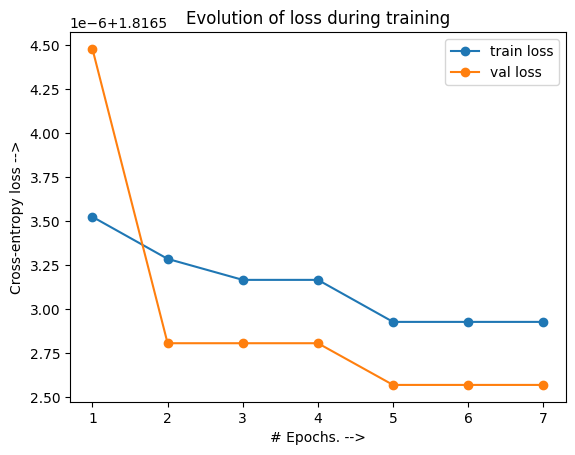

In [75]:
plt.plot(list(range(1,8)), train_loss_track, "o-", label="train loss")
plt.plot(list(range(1,8)), val_loss_track, "o-", label="val loss")
plt.legend()
plt.title("Evolution of loss during training")
plt.xlabel("# Epochs. -->")
plt.ylabel("Cross-entropy loss -->")
plt.show()

## Save Model

In [42]:
torch.save(model.state_dict(), '/scratch/Rish/BERT_model.pth')

## Testing

In [ ]:
model.eval()

In [63]:
def restore(sent_in):
    sent_in = sent_in.split(" ")
    fin = ""
    for word in sent_in:
        fin += word
        pred = torch.argmax(model(BERT_encoding(fin).to(device)))
        while pred != 14:
            fin += idx2punc[pred] + " "
            pred = torch.argmax(model.predict(fin))
        fin += " "
    return fin

In [64]:
def remove_all_punc(s_in):
  fin = ""
  for i in s_in:
    if i.isalpha() or i==" ":
      fin += i
  return fin

In [71]:
orig_punc = [ " ".join(i) for i in DS_test ]
wo_punc = [ remove_all_punc(i) for i in orig_punc]
restored_punc = [restore(i) for i in tqdm(wo_punc)]



100%|███████████████████████████████████████| 476/476 [1:03:59<00:00,  8.07s/it]


In [72]:
def calculate_jaccard_similarity(original_sentence, restored_sentence):
    original_tokens = set(word_tokenize(original_sentence))
    restored_tokens = set(word_tokenize(restored_sentence))

    # Calculate Jaccard similarity
    intersection = len(original_tokens.intersection(restored_tokens))
    union = len(original_tokens.union(restored_tokens))

    jaccard_similarity = intersection / union if union != 0 else 0
    return jaccard_similarity

In [73]:
fin_score = sum( [calculate_jaccard_similarity(orig, restored) for orig, restored in zip(orig_punc, restored_punc)] ) / len(all_sents)

In [74]:
print("Final score for Fine-tuned BERT:", fin_score)

Final score for Fine-tuned BERT: 0.18189592922375233
